<h1>Prediction of mechanical properties of low alloy steels</h1>

The goal of this project is to predict mechanical properties of low alloy steels from composition and temperature.<br><br>

Supervised machine learning method implementation step are:
<ol>
  <li>EDA</li>
  <li>feature engineering</li>
  <li>feature selection</li>
  <li>regression</li>
  <li>discussion</li>
</ol>

<h2>About the dataset:</h2><br>
The dataset was published at Kaggle, but today it isn't available.<br><br>

<b>Context</b><br>
Currently there are no precise theoretical methods to predict mechanical properties of steels. All the methods available are by backed by statistics and extensive physical testing of the materials. Since testing each material with different composition is a highly tedious task (imagine the number of possibilities!), let's apply our knowledge of machine learning and statistics to solve this problem.<br><br>

<b>Content</b><br>
This dataset contains compositions by weight percentages of low-alloy steels along with the temperatures at which the steels were tested and the values mechanical properties observed during the tests. The alloy code is a string unique to each alloy. Weight percentages of alloying metals and impurities like Aluminum, copper, manganese, nitrogen, nickel, cobalt, carbon, etc are given in columns. The temperature in celsius for each test is mentioned in a column. Lastly mechanical properties including tensile strength, yield strength, elongation and reduction in area are given in separate columns. The dataset contains 915 rows.

<b>Results</b><br>
Strength properties are easier to predict with R square above 0.96. Geometrical properties are less predictable with R square above 0.86.
<table>
  <tr>
    <th>Evaluation Criteria</th>
    <th>0.2% Proof Stress (MPa)</th>
    <th>Tensile Strength (MPa)</th>
    <th>Elongation (%)</th>
    <th>Reduction in Area (%)</th>
  </tr>
  <tr>
    <th>RMSE train</th>
    <th>488</th>
    <th>474</th>
    <th>5.91</th>
    <th>13.68</th>
  </tr>
  <tr>
    <th>RMSE test</th>
    <th>352</th>
    <th>614</th>
    <th>9.93</th>
    <th>18.49</th>
  </tr>
  <tr>
    <th>R2 train</th>
    <th>0.97</th>
    <th>0.97</th>
    <th>0.93</th>
    <th>0.91</th>
  </tr>
  <tr>
    <th>R2 test</th>
    <th>0.98</th>
    <th>0.96</th>
    <th>0.86</th>
    <th>0.86</th>
  </tr>
</table>

<h2>1. EDA</h2>

In [1]:
# importing libraries
from platform import python_version
import warnings

# for working with arrays and dataframes
import numpy as np
import pandas as pd

# for plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import scipy
import scipy.stats as stats # for Q-Q plots

# for plotting
import matplotlib.pyplot as plt #for plotting data
import seaborn as sns # for plotting data
import scipy
import scipy.stats as stats # for Q-Q plots

# for validation and evelueation
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error

# for classification
import xgboost
from xgboost import XGBRegressor

In [2]:
# showing versions
print('Python version:',python_version())
print('NumPy version:',np.__version__)
print('Pandas version:',pd.__version__)
print('SciPy version:',scipy.__version__)
print('Sklearn version:',sklearn.__version__)
print('XGBoost version:',xgboost.__version__)

Python version: 3.7.14
NumPy version: 1.21.6
Pandas version: 1.3.5
SciPy version: 1.7.3
Sklearn version: 1.0.2
XGBoost version: 0.90


In [3]:
# settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None, 'display.max_columns', None)

In [4]:
# importing the dataset
df = pd.read_csv("MatNavi Mechanical properties of low-alloy steels.csv")
print(f"{df.shape[1]} columns, {df.shape[0]} rows")
# checking duplicated rows
print(f"{df.duplicated().sum()} duplicated rows")
df.head()

20 columns, 915 rows
0 duplicated rows


Alloy code     C    Si    Mn      P      S     Ni    Cr    Mo    Cu    V  \
0        MBB  0.12  0.36  0.52  0.009  0.003  0.089  0.97  0.61  0.04  0.0   
1        MBB  0.12  0.36  0.52  0.009  0.003  0.089  0.97  0.61  0.04  0.0   
2        MBB  0.12  0.36  0.52  0.009  0.003  0.089  0.97  0.61  0.04  0.0   
3        MBB  0.12  0.36  0.52  0.009  0.003  0.089  0.97  0.61  0.04  0.0   
4        MBB  0.12  0.36  0.52  0.009  0.003  0.089  0.97  0.61  0.04  0.0   

      Al       N  Ceq  Nb + Ta   Temperature (°C)   0.2% Proof Stress (MPa)  \
0  0.003  0.0066  0.0      0.0                 27                       342   
1  0.003  0.0066  0.0      0.0                100                       338   
2  0.003  0.0066  0.0      0.0                200                       337   
3  0.003  0.0066  0.0      0.0                300                       346   
4  0.003  0.0066  0.0      0.0                400                       316   

    Tensile Strength (MPa)   Elongation (%)   Reduction in Area (%)  
0                      490               30                      71  
1                      454               27                      72  
2                      465               23                      69  
3                      495               21                      70  
4                      489               26                      79

In [5]:
# fixing column names, removing swhite spaces
print('Columns before fixing:')
print(df.columns.to_list())
cols = [col.strip() for col in df.columns.to_list()]
df.columns = cols
print('Columns after fixing:')
print(df.columns.to_list())

Columns before fixing:
['Alloy code', ' C', ' Si', ' Mn', ' P', ' S', ' Ni', ' Cr', ' Mo', ' Cu', 'V', ' Al', ' N', 'Ceq', 'Nb + Ta', ' Temperature (°C)', ' 0.2% Proof Stress (MPa)', ' Tensile Strength (MPa)', ' Elongation (%)', ' Reduction in Area (%)']
Columns after fixing:
['Alloy code', 'C', 'Si', 'Mn', 'P', 'S', 'Ni', 'Cr', 'Mo', 'Cu', 'V', 'Al', 'N', 'Ceq', 'Nb + Ta', 'Temperature (°C)', '0.2% Proof Stress (MPa)', 'Tensile Strength (MPa)', 'Elongation (%)', 'Reduction in Area (%)']


In [6]:
# showing data types
df.dtypes

Alloy code                  object
C                          float64
Si                         float64
Mn                         float64
P                          float64
S                          float64
Ni                         float64
Cr                         float64
Mo                         float64
Cu                         float64
V                          float64
Al                         float64
N                          float64
Ceq                        float64
Nb + Ta                    float64
Temperature (°C)             int64
0.2% Proof Stress (MPa)      int64
Tensile Strength (MPa)       int64
Elongation (%)               int64
Reduction in Area (%)        int64
dtype: object

In [7]:
# making a list of the variables that contain missing values
vars_with_na = [var for var in df.columns if df[var].isnull().sum() > 0]

# determining percentage of missing values (expressed as decimals)
# and displaying the result ordered by percent of missin data

df[vars_with_na].isnull().mean().sort_values(ascending=False)

Series([], dtype: float64)

In [8]:
# identifying categorical values
# capturing type object
cat_vars = [var for var in df.columns if df[var].dtype == 'O']
cat_vars

['Alloy code']

<h3>Numerical variables</h3>

In [9]:
# identifying the numerical variables
num_vars = [var for var in df.columns if var not in cat_vars]
num_vars

['C',
 'Si',
 'Mn',
 'P',
 'S',
 'Ni',
 'Cr',
 'Mo',
 'Cu',
 'V',
 'Al',
 'N',
 'Ceq',
 'Nb + Ta',
 'Temperature (°C)',
 '0.2% Proof Stress (MPa)',
 'Tensile Strength (MPa)',
 'Elongation (%)',
 'Reduction in Area (%)']

In [10]:
# function to create histogram, Q-Q plot and boxplot
def diagnostic_plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')
    
    plt.show()

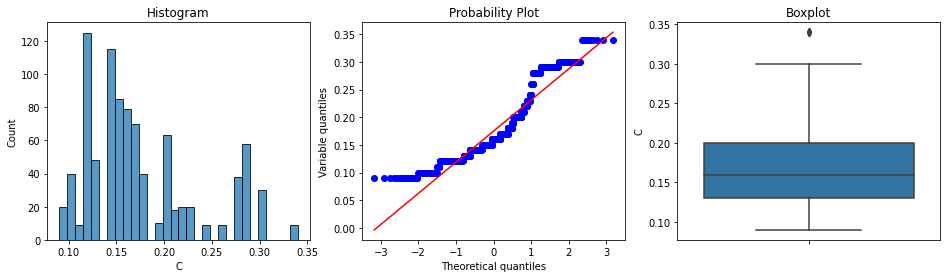

Skewnessis of C is 0.95


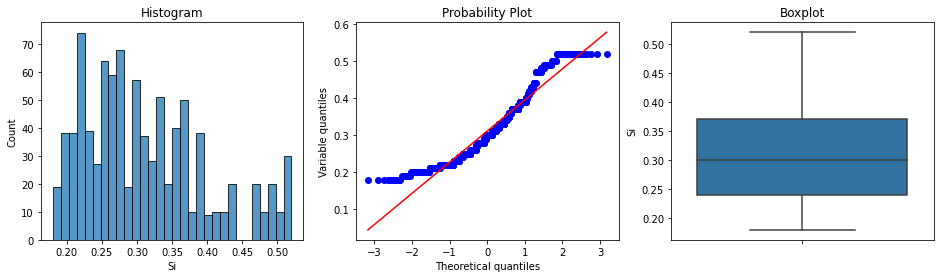

Skewnessis of Si is 0.75


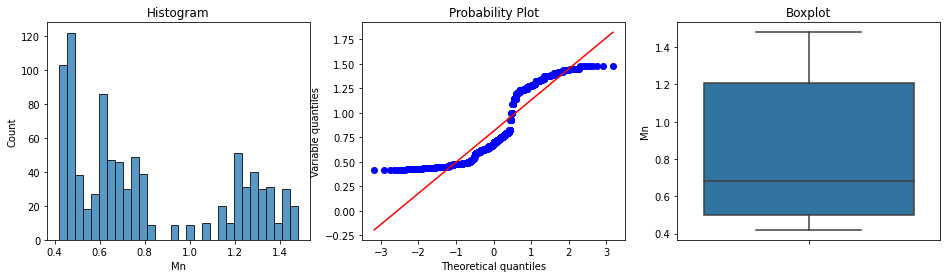

Skewnessis of Mn is 0.61


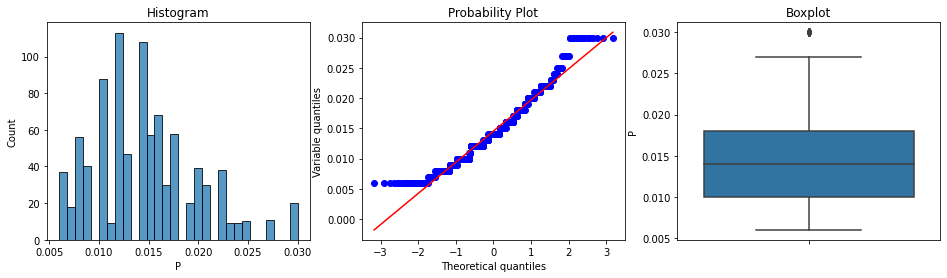

Skewnessis of P is 0.69


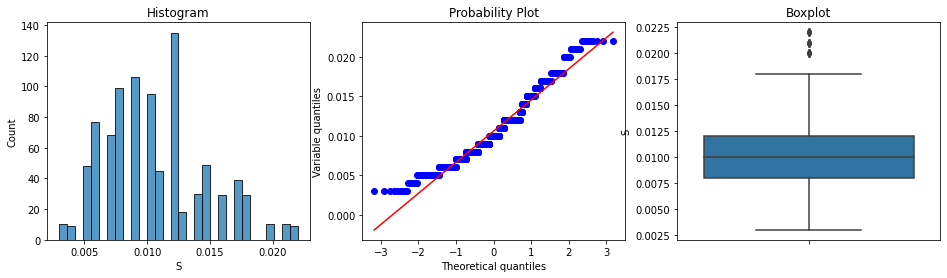

Skewnessis of S is 0.62


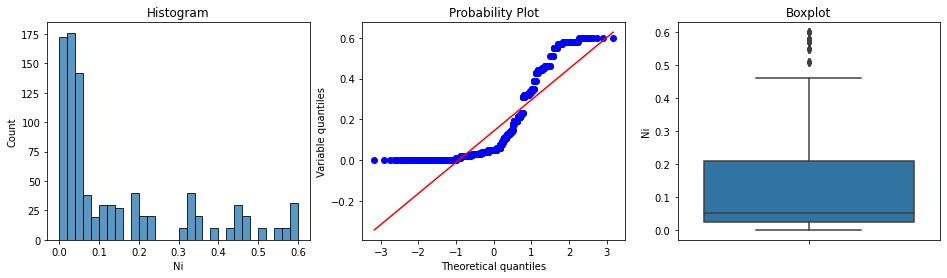

Skewnessis of Ni is 1.29


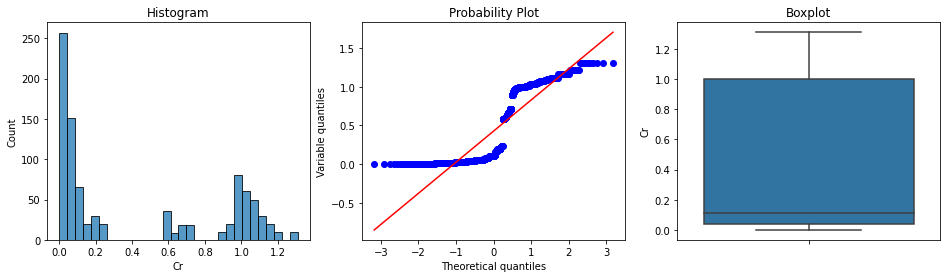

Skewnessis of Cr is 0.53


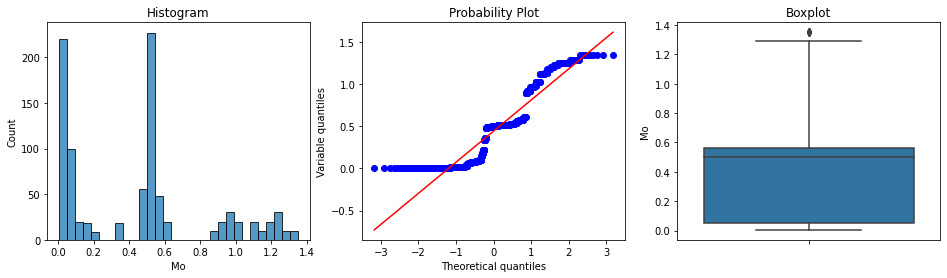

Skewnessis of Mo is 0.62


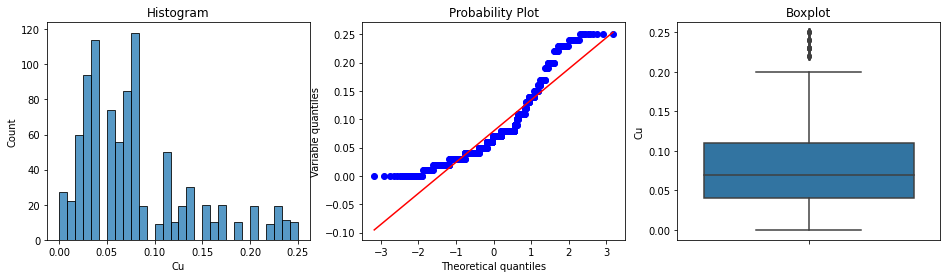

Skewnessis of Cu is 1.20


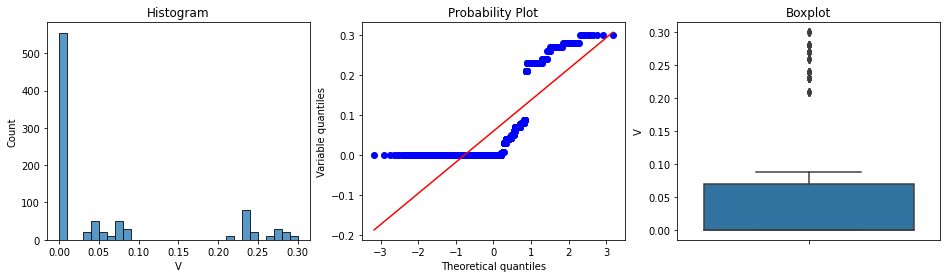

Skewnessis of V is 1.38


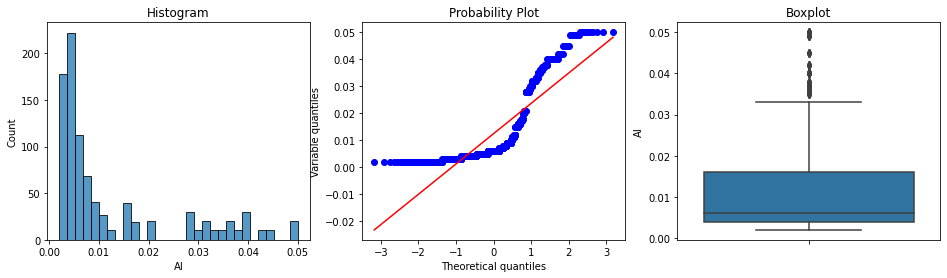

Skewnessis of Al is 1.43


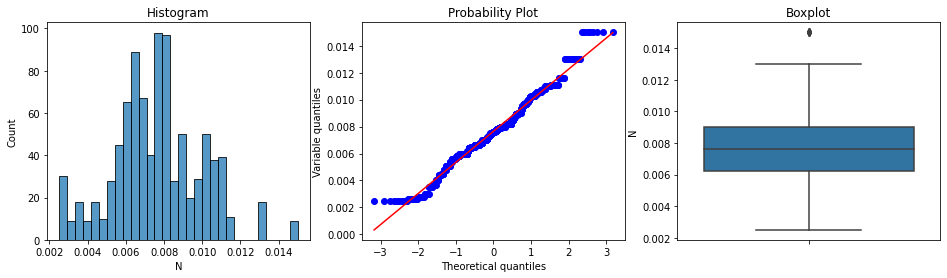

Skewnessis of N is 0.23


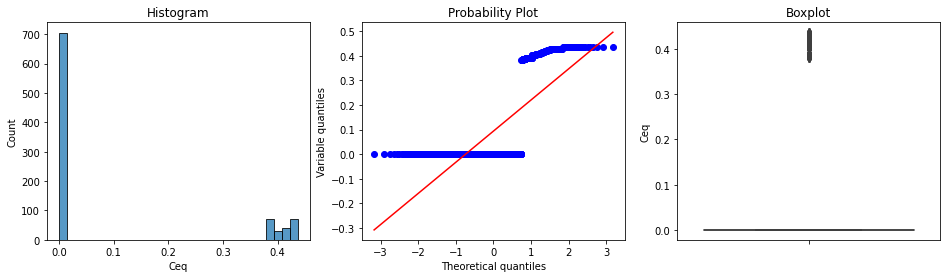

Skewnessis of Ceq is 1.30


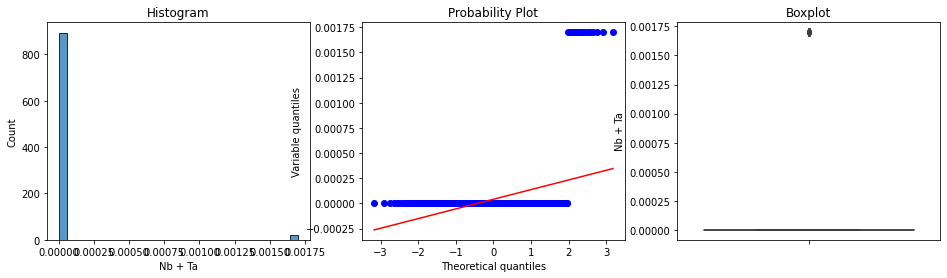

Skewnessis of Nb + Ta is 6.22


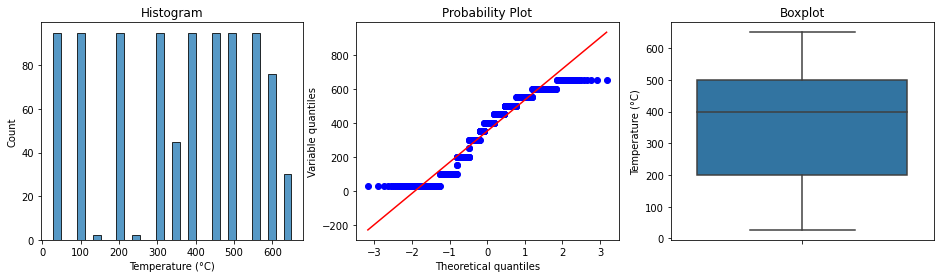

Skewnessis of Temperature (°C) is -0.32


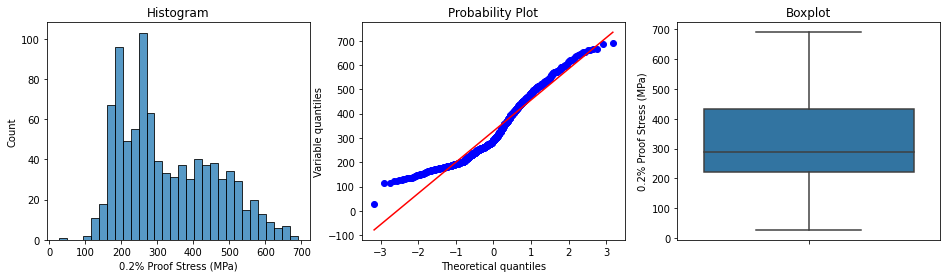

Skewnessis of 0.2% Proof Stress (MPa) is 0.57


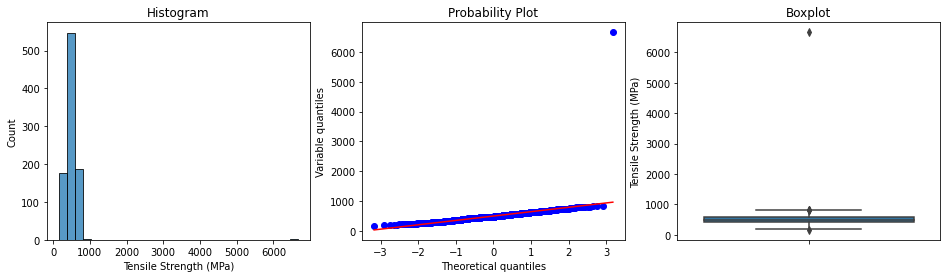

Skewnessis of Tensile Strength (MPa) is 18.64


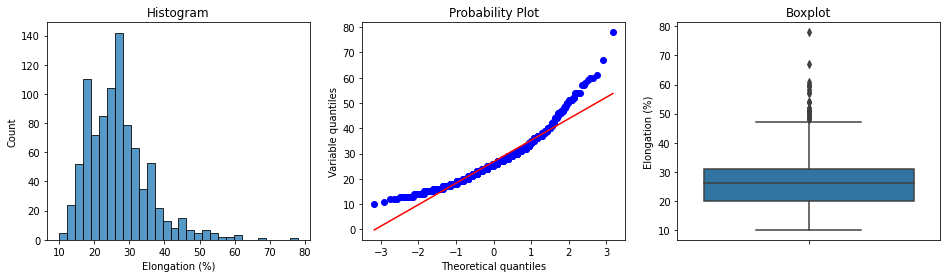

Skewnessis of Elongation (%) is 1.22


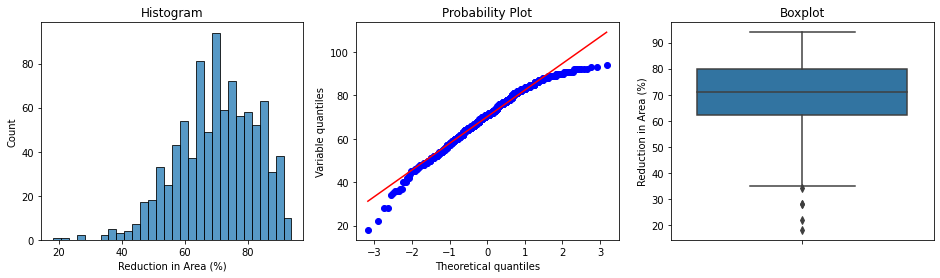

Skewnessis of Reduction in Area (%) is -0.51


In [11]:
# plotting numerical variables
for variable in num_vars:
    diagnostic_plots(df, variable)
    # printing skewness
    skewness = df[variable].skew()
    print("Skewnessis of", variable, "is {:.2f}".format(skewness))

Discussion: Prominent outliers in Tensile Strength (MPa). Nb + Ta behaves like a categorical variable.

In [12]:
# moving 'Nb + Ta' to categorical variables list
cat_vars += ['Nb + Ta']
print(f"Categotival variables: {cat_vars}")
num_vars.remove('Nb + Ta')
print(f"Numerical variables: {num_vars}")

Categotival variables: ['Alloy code', 'Nb + Ta']
Numerical variables: ['C', 'Si', 'Mn', 'P', 'S', 'Ni', 'Cr', 'Mo', 'Cu', 'V', 'Al', 'N', 'Ceq', 'Temperature (°C)', '0.2% Proof Stress (MPa)', 'Tensile Strength (MPa)', 'Elongation (%)', 'Reduction in Area (%)']


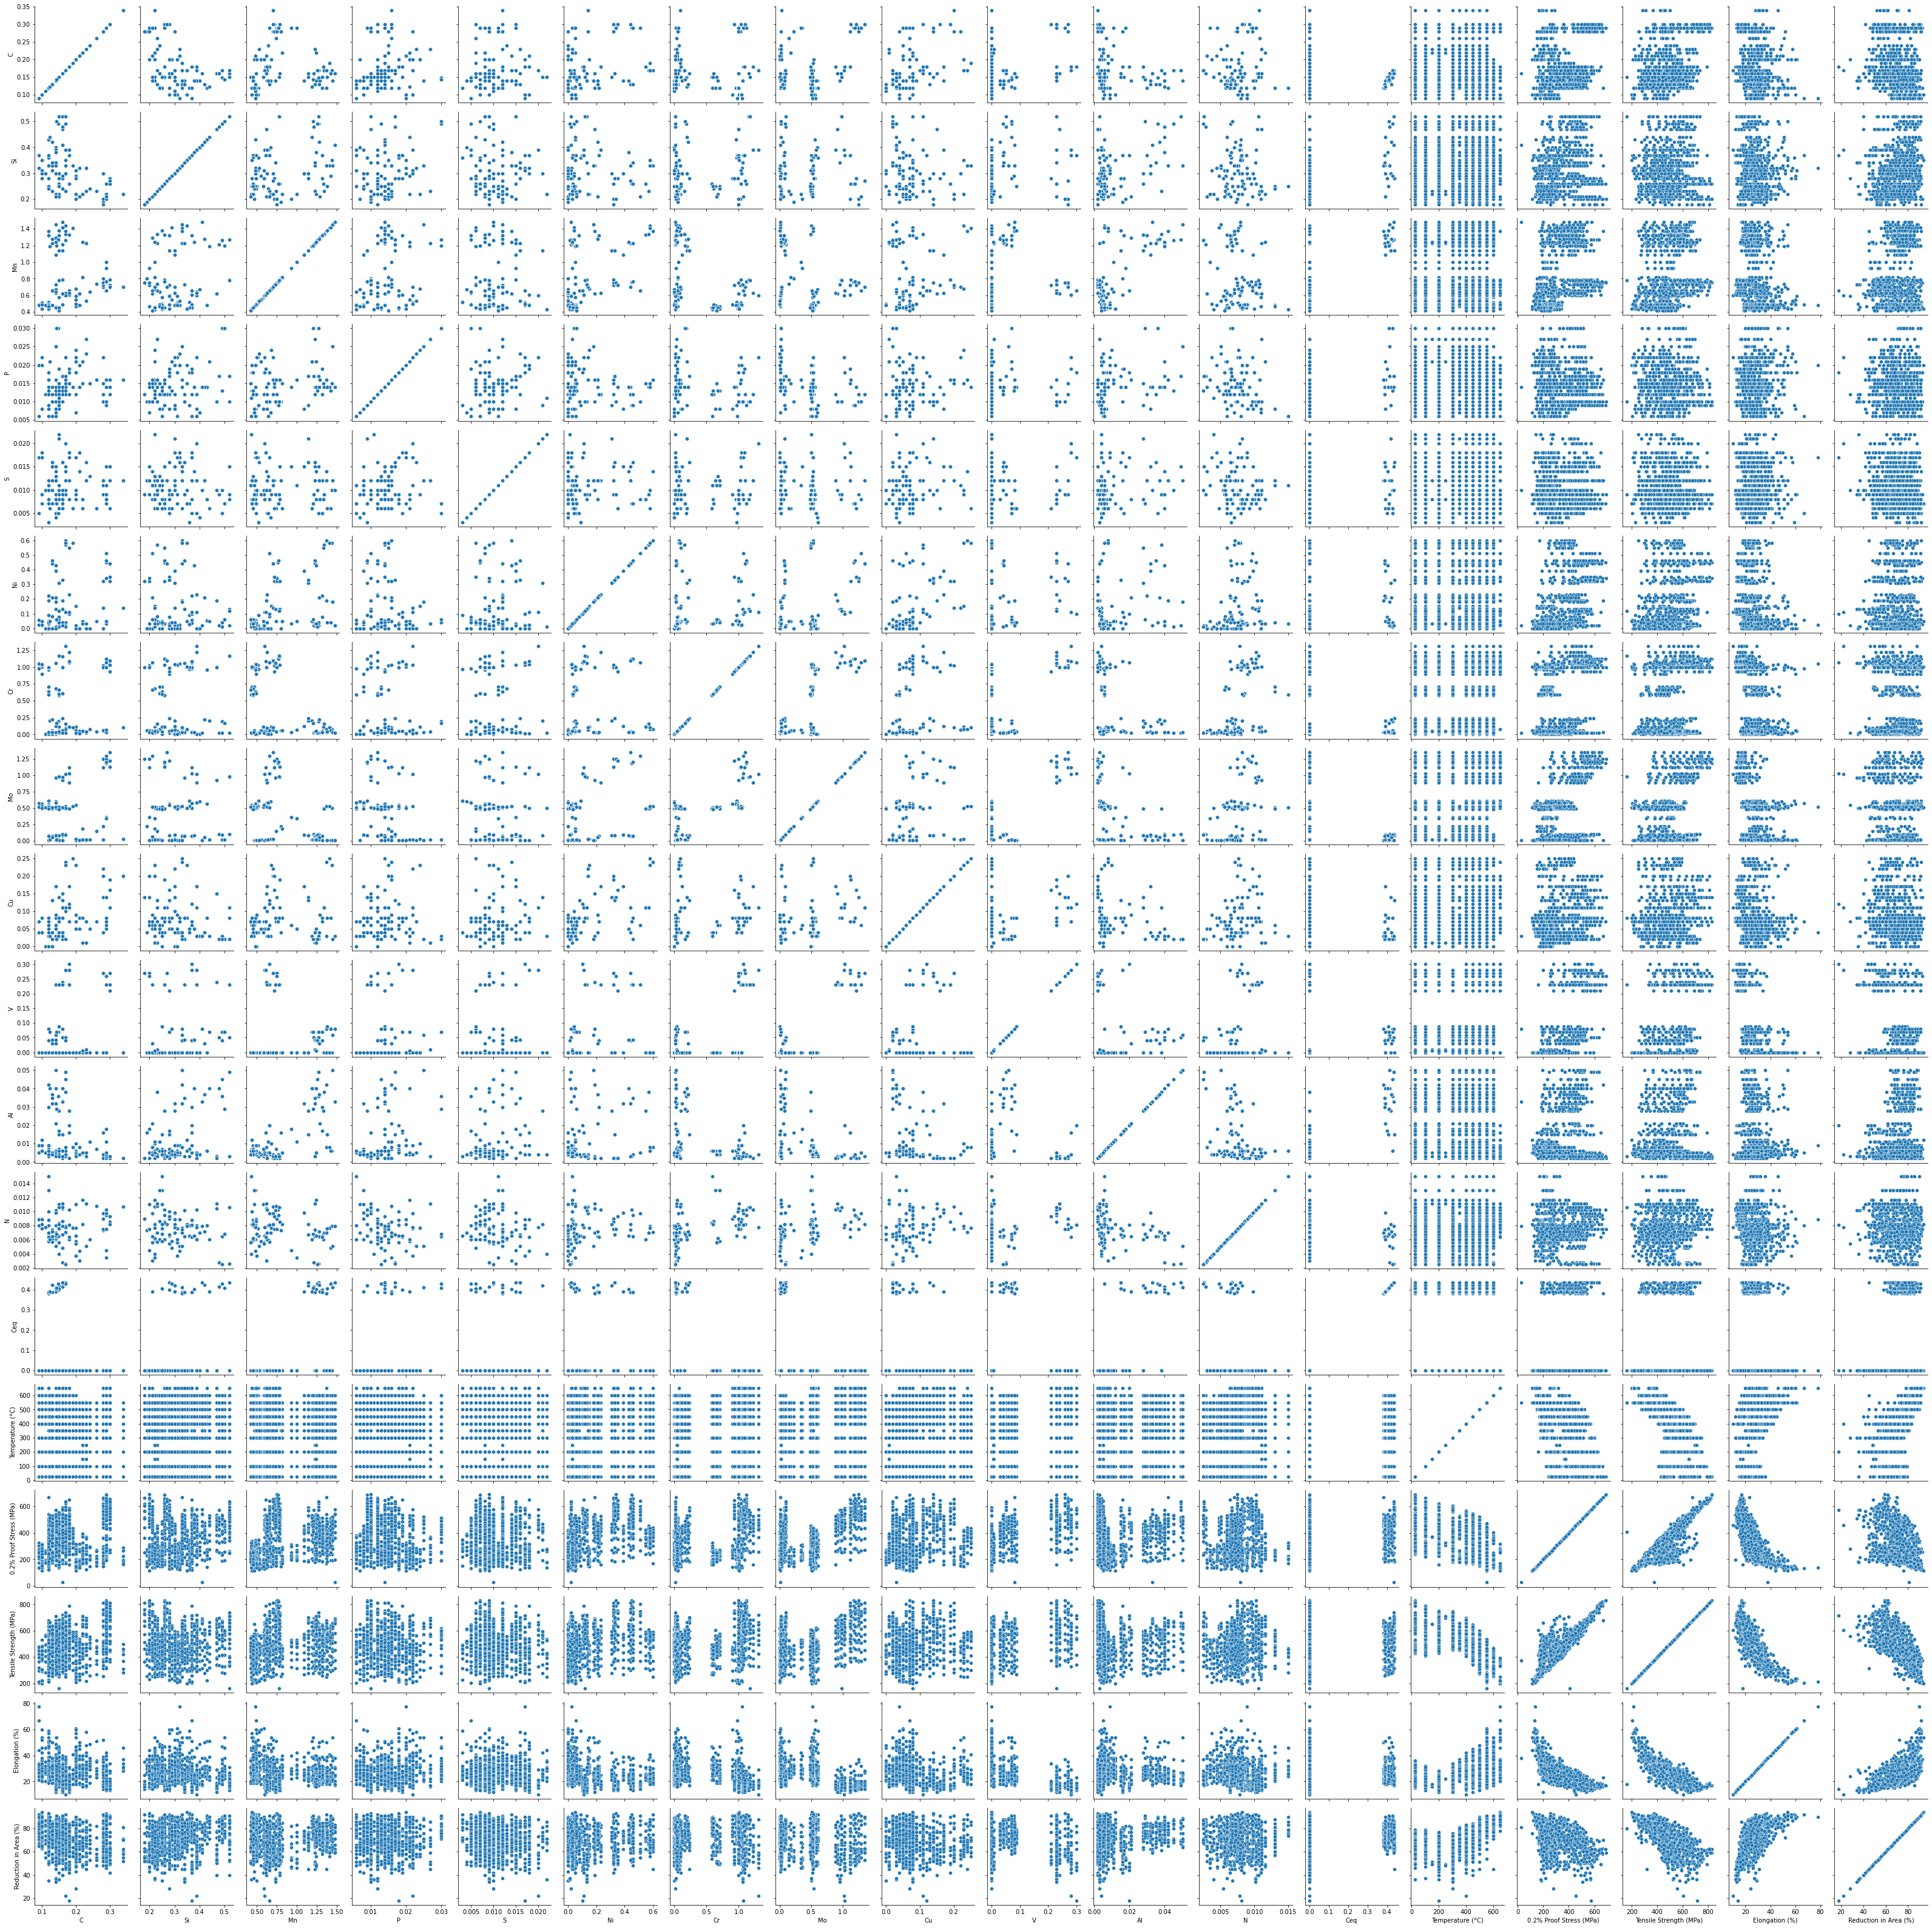

In [13]:
# plotting scatterplots with pairs of numerical variables
# w/o outliers in 'Tensile Strength (MPa)'
g = sns.PairGrid(df[num_vars][df['Tensile Strength (MPa)'] < 2000])
g.map(sns.scatterplot)

In [14]:
num_vars

['C',
 'Si',
 'Mn',
 'P',
 'S',
 'Ni',
 'Cr',
 'Mo',
 'Cu',
 'V',
 'Al',
 'N',
 'Ceq',
 'Temperature (°C)',
 '0.2% Proof Stress (MPa)',
 'Tensile Strength (MPa)',
 'Elongation (%)',
 'Reduction in Area (%)']

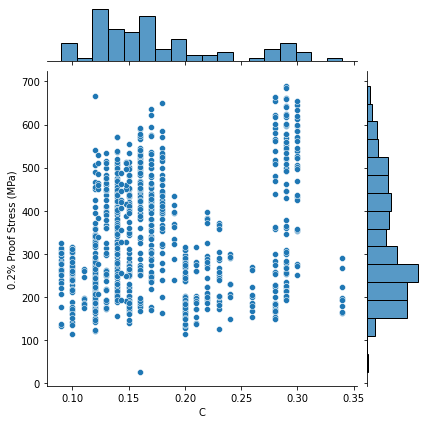

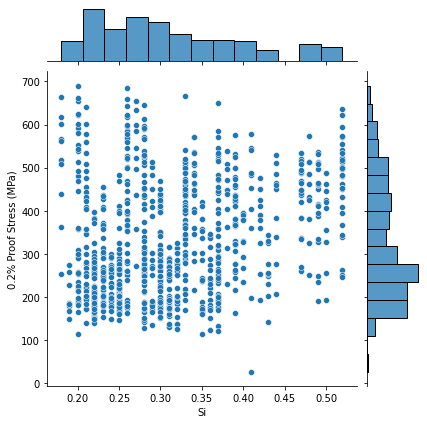

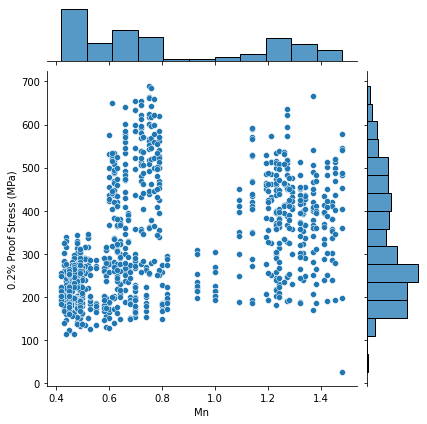

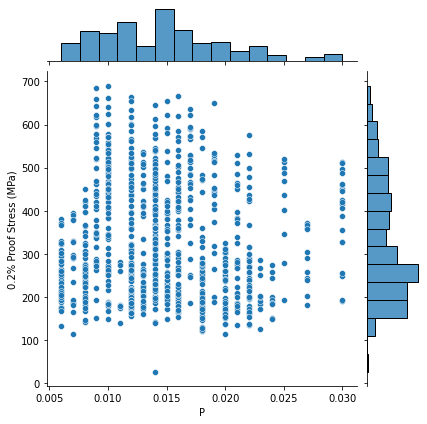

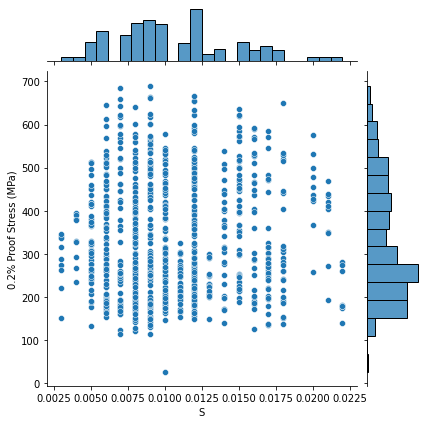

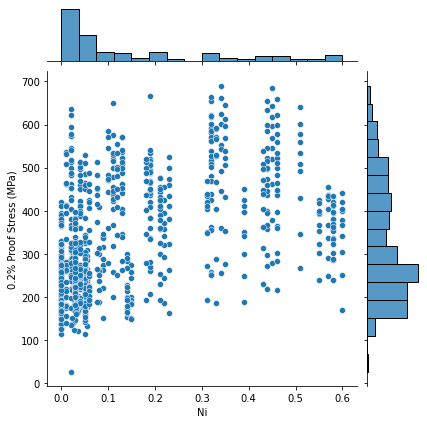

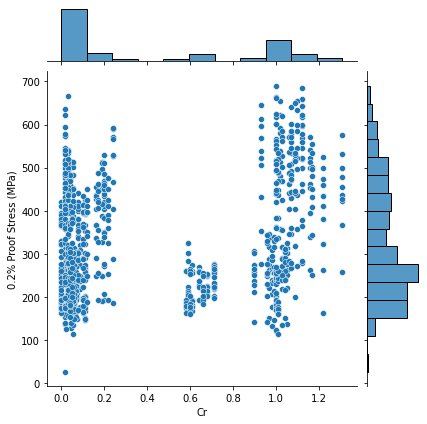

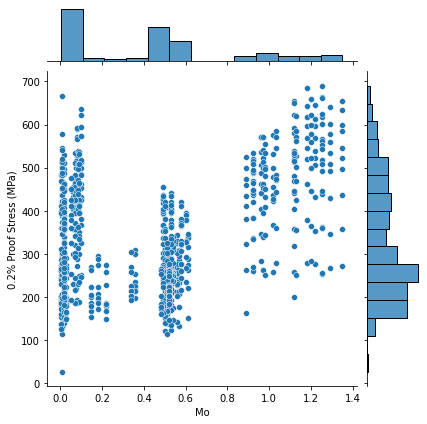

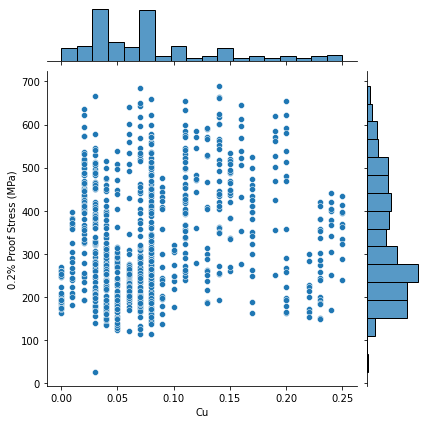

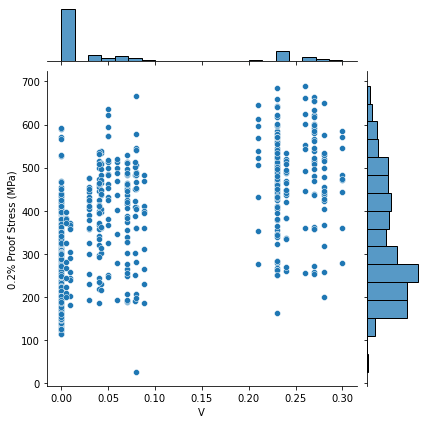

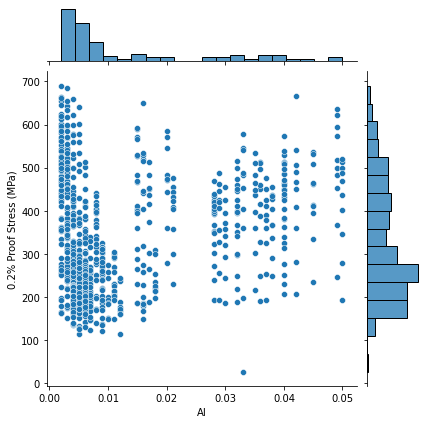

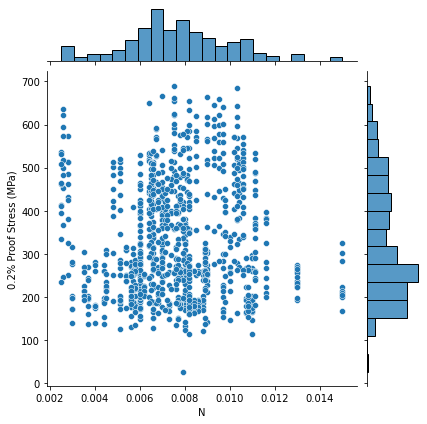

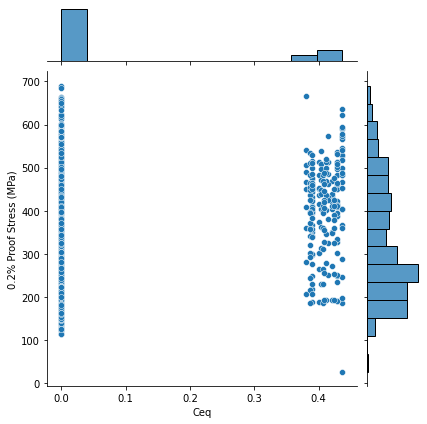

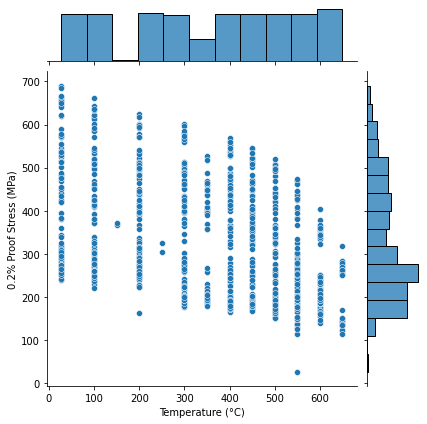

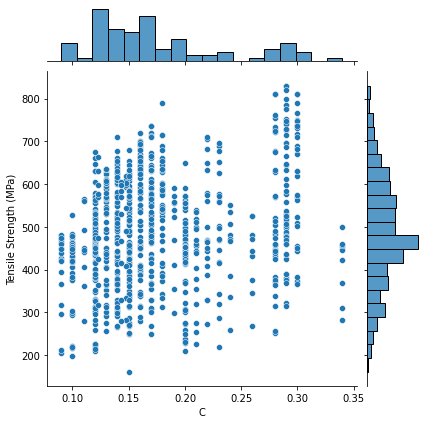

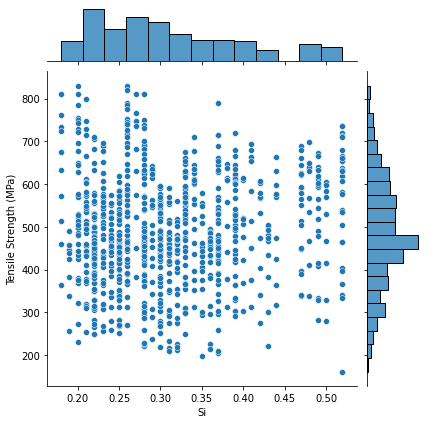

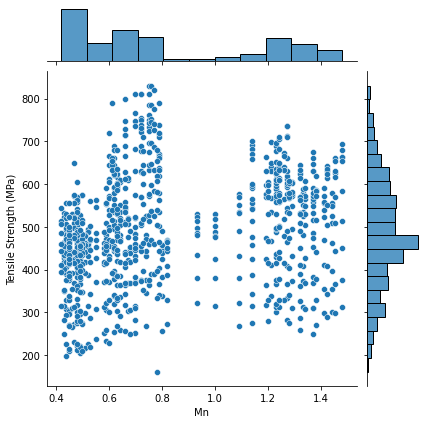

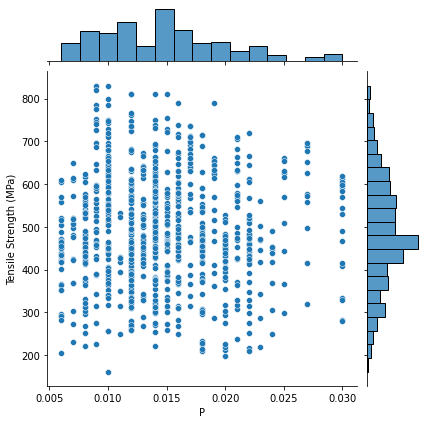

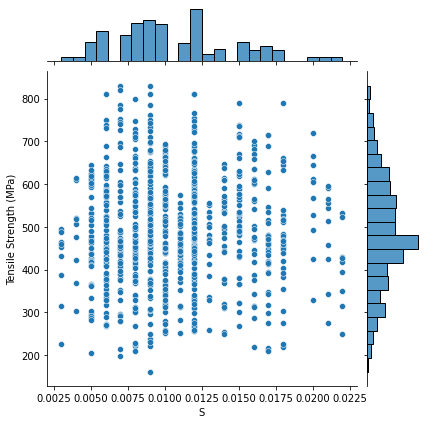

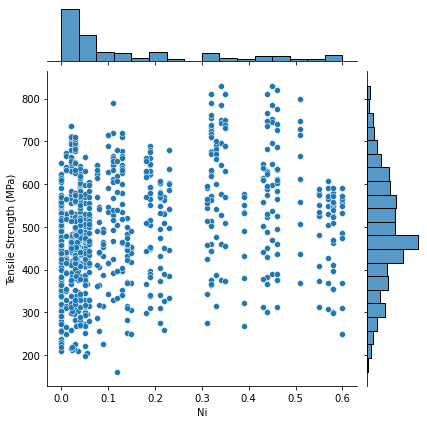

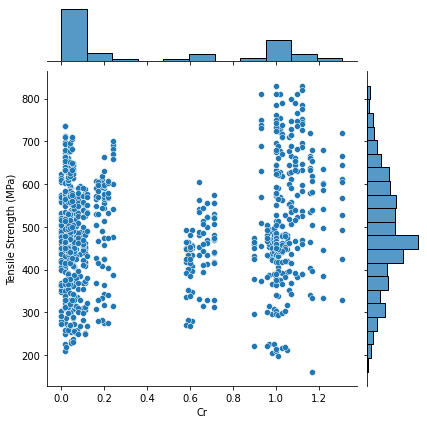

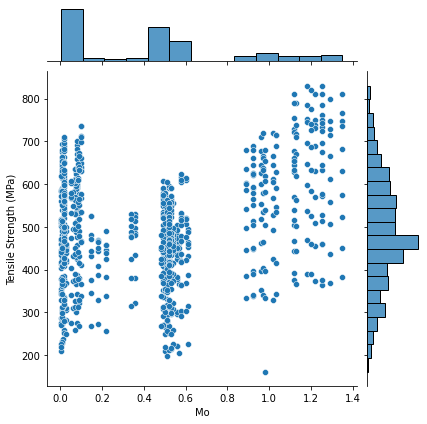

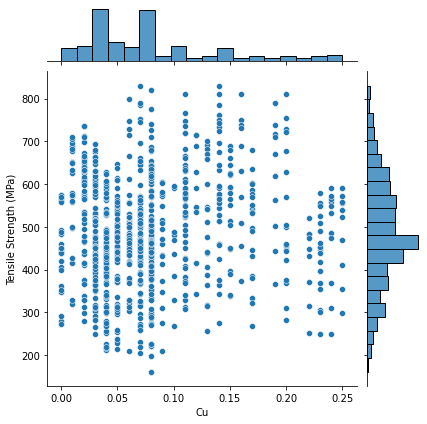

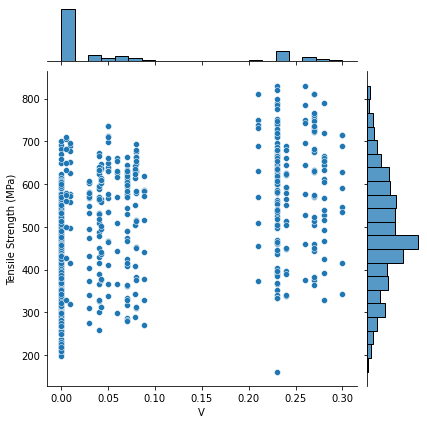

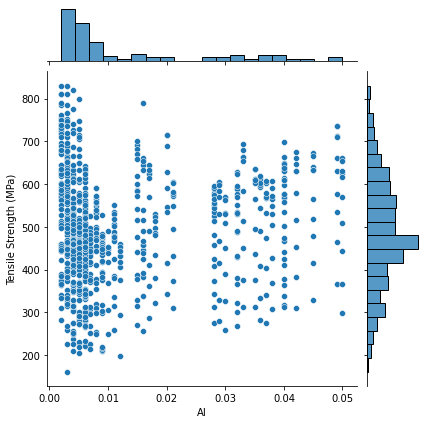

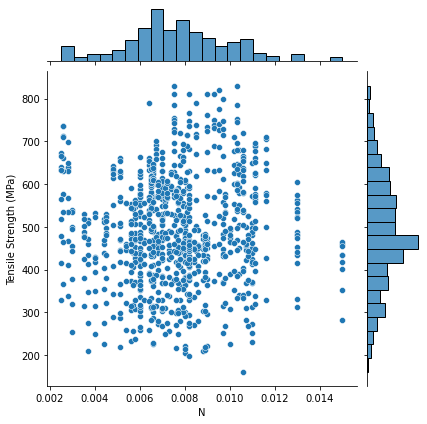

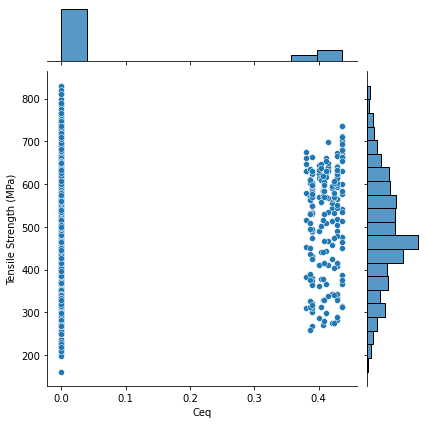

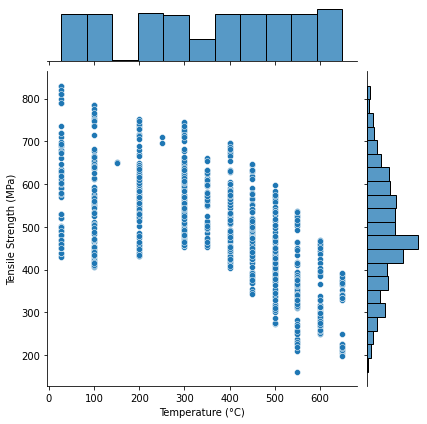

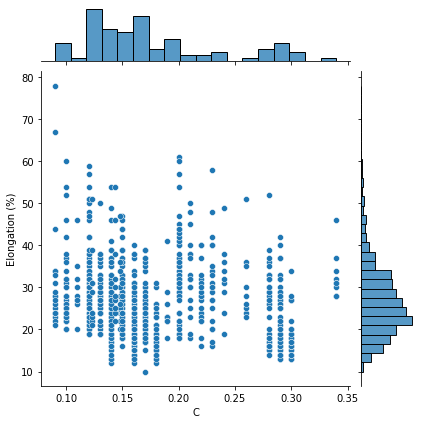

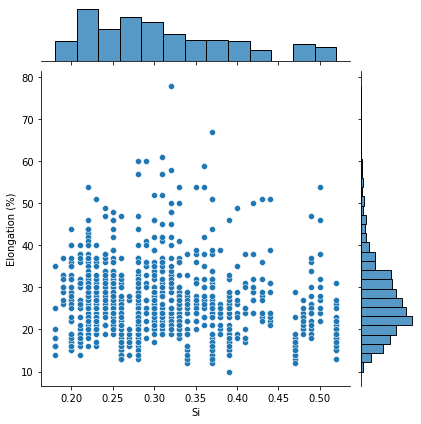

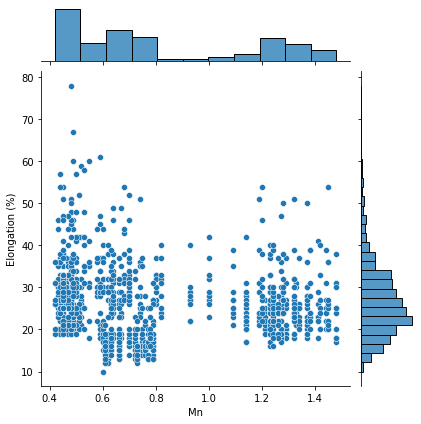

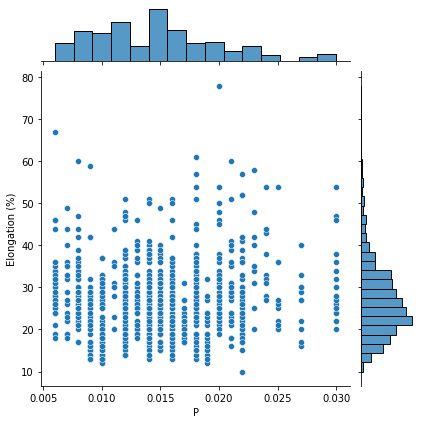

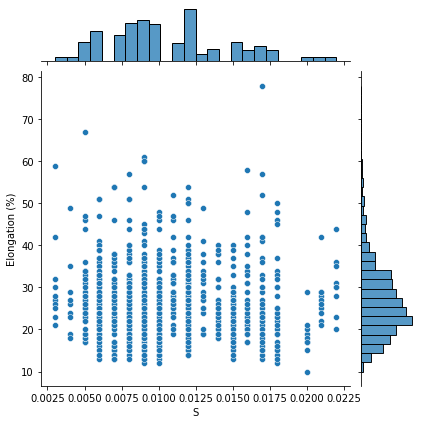

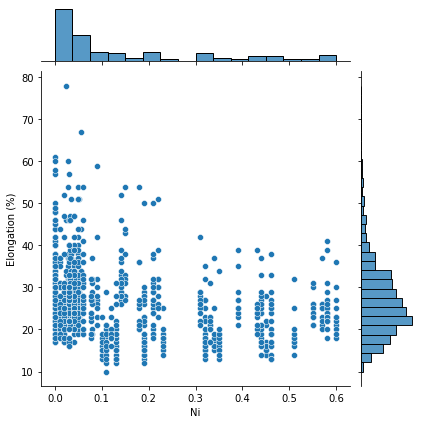

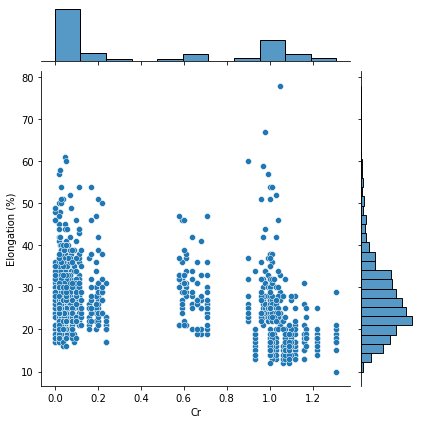

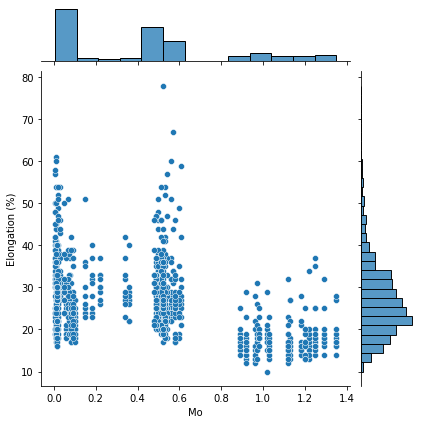

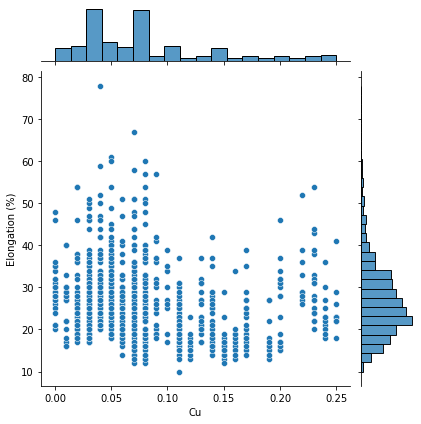

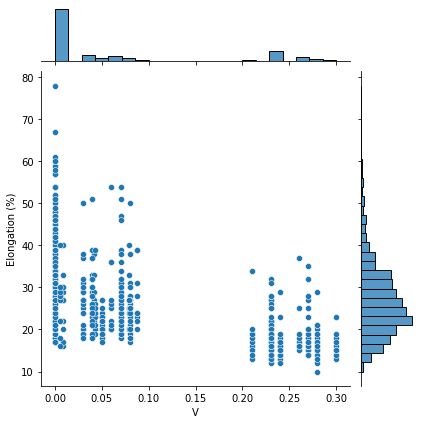

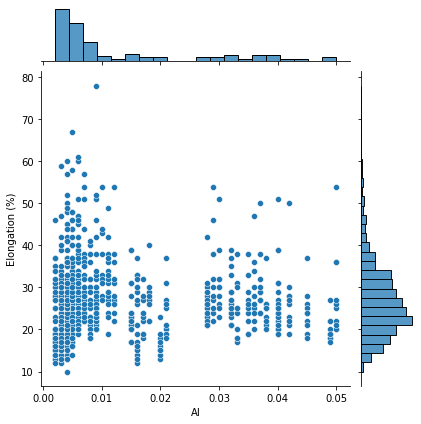

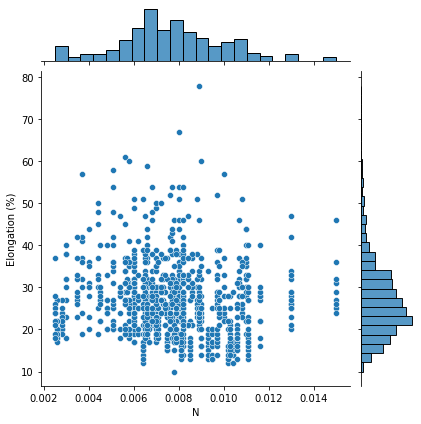

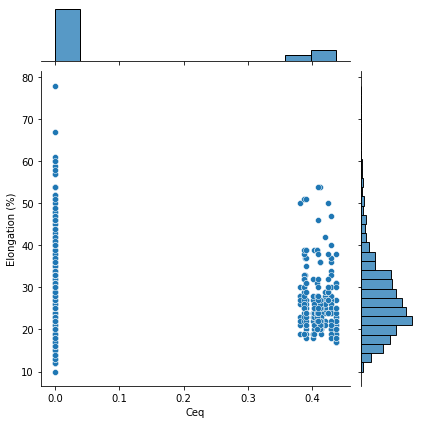

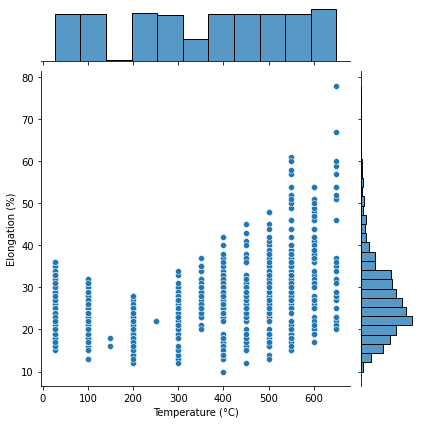

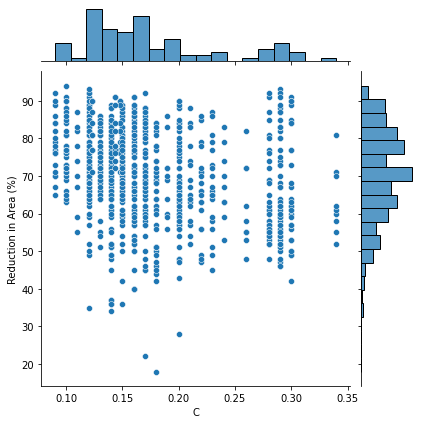

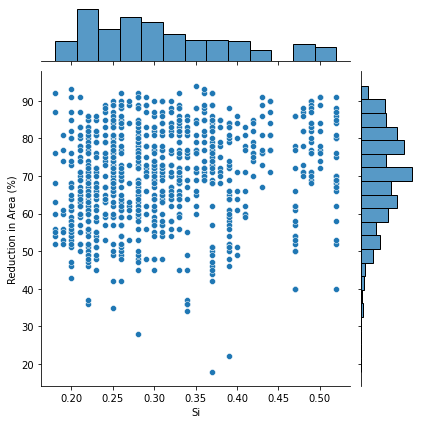

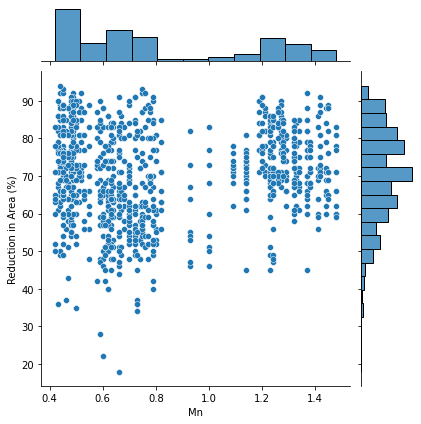

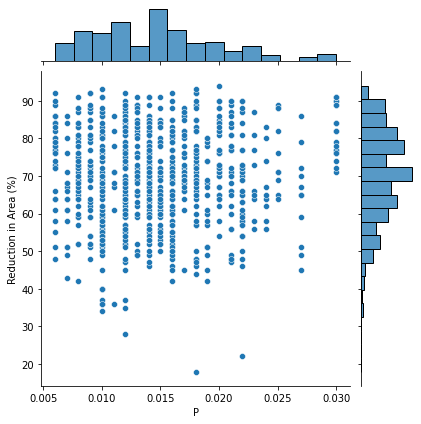

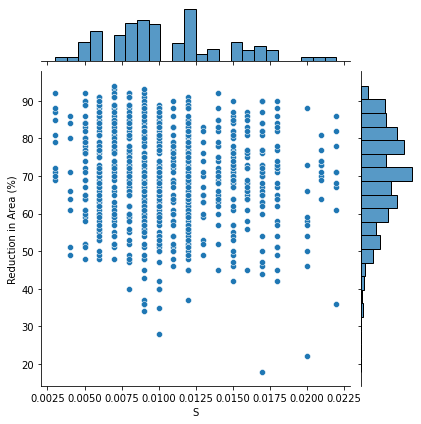

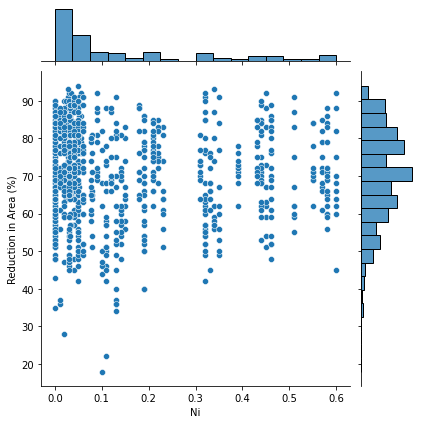

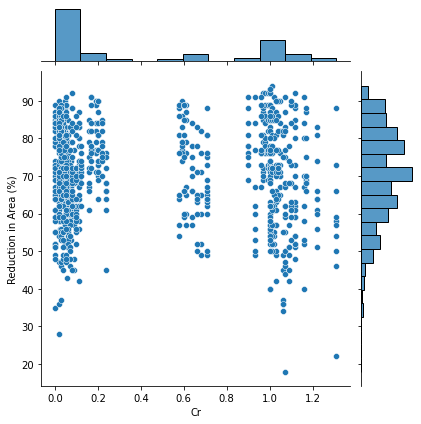

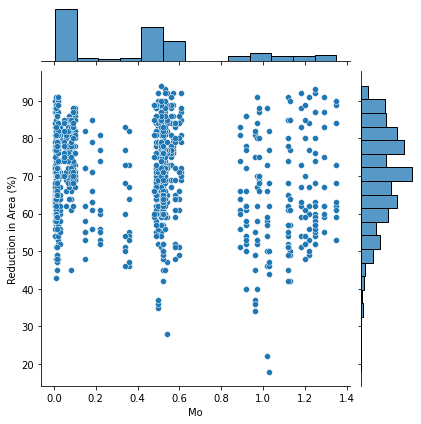

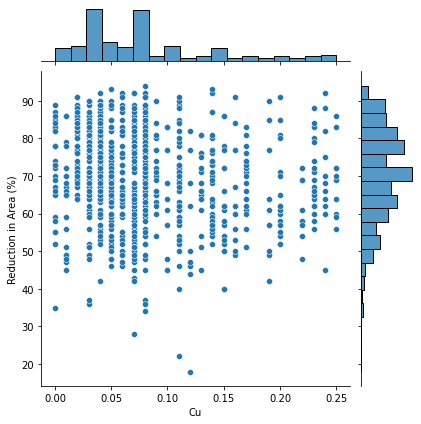

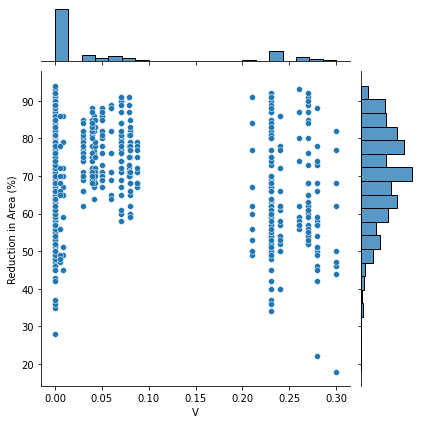

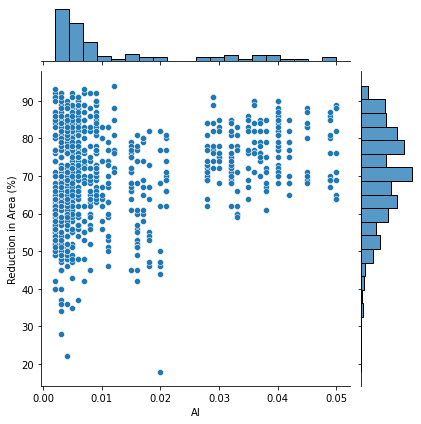

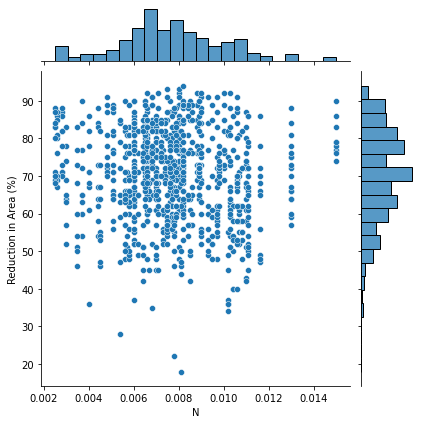

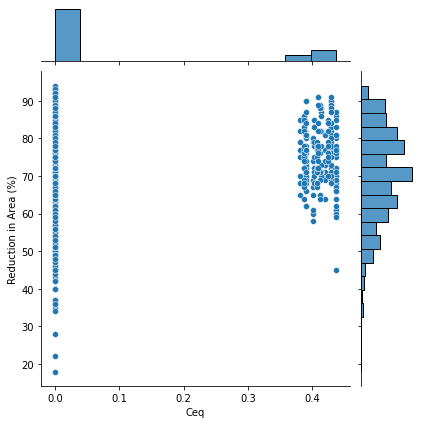

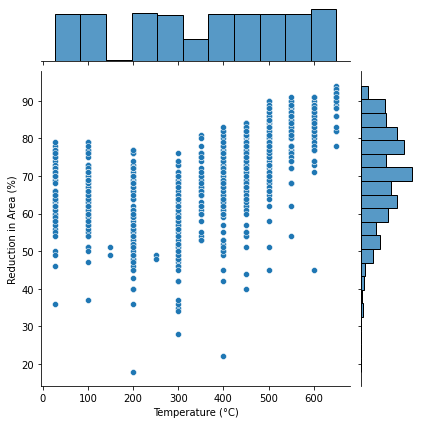

In [15]:
# closer look at influence of numerical variables on the targers
for target in ['0.2% Proof Stress (MPa)', 'Tensile Strength (MPa)',
                   'Elongation (%)', 'Reduction in Area (%)']:
    for var in ['C', 'Si', 'Mn', 'P', 'S', 'Ni', 'Cr', 'Mo', 'Cu', 'V', 'Al',
                'N', 'Ceq','Temperature (°C)']:
        sns.jointplot(data=df[df['Tensile Strength (MPa)'] < 2000],
                        x=var, y=target)

Discussion<br>
'Temperature (°C)' highly influences all the target variables. 'P'and 'Cu' are least influencing. Other variables influence, but less then temperature.



<h3>Categorical variables</h3>

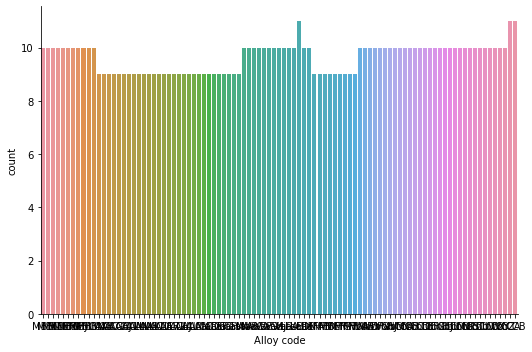

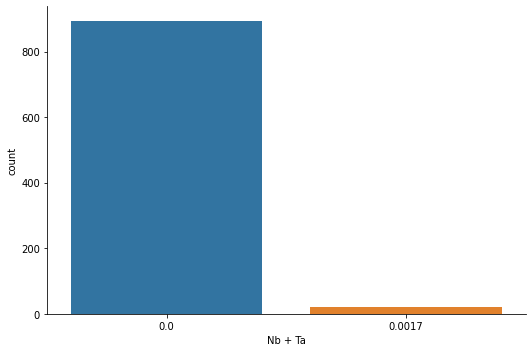

In [16]:
# plotting categorical variables
for var in cat_vars:
    ax = sns.catplot(var, data=df, kind='count', aspect=1.5)

In [17]:
# closer look at 'Alloy code'
df_alloy_code = df['Alloy code'].value_counts(dropna=False).to_frame()
for code in df_alloy_code.index:
    df_alloy_code.loc[[code], ['0.2% Proof Stress (MPa)']] = \
        df['0.2% Proof Stress (MPa)'][df['Alloy code'] == code].mean()
    df_alloy_code.loc[[code], ['Tensile Strength (MPa)']] = \
        df['Tensile Strength (MPa)'][df['Alloy code'] == code].mean()
    df_alloy_code.loc[[code], ['Elongation (%)']] = \
        df['Elongation (%)'][df['Alloy code'] == code].mean()
    df_alloy_code.loc[[code], ['Reduction in Area (%)']] = \
        df['Reduction in Area (%)'][df['Alloy code'] == code].mean()
df_alloy_code

Alloy code  0.2% Proof Stress (MPa)  Tensile Strength (MPa)  \
CCB          11               298.545455              577.363636   
CCA          11               288.636364              571.181818   
LaD          11               352.545455              477.545455   
VbA          10               445.500000              558.800000   
VbN          10               445.300000              507.900000   
VbM          10               392.800000              531.100000   
VbJ          10               455.500000              564.100000   
VbH          10               455.500000              595.000000   
VbG          10               427.700000              535.600000   
VbF          10               472.700000             1184.200000   
VbD          10               460.400000              554.200000   
VbB          10               436.800000              545.300000   
LaF          10               355.900000              487.700000   
CbB          10               388.000000              526.100000   
LaE          10               346.700000              478.400000   
LaB          10               376.700000              502.400000   
LaA          10               361.500000              493.000000   
VaR          10               510.200000              630.200000   
MBC          10               240.000000              401.500000   
VaH          10               513.700000              634.200000   
VaG          10               529.600000              645.400000   
CbA          10               373.900000              487.200000   
CbC          10               471.700000              572.600000   
VaD          10               505.100000              625.800000   
CbD          10               435.900000              557.300000   
CbZ          10               407.600000              558.800000   
CbY          10               366.200000              495.300000   
CbX          10               429.000000              555.200000   
CbW          10               378.100000              497.900000   
CbV          10               350.700000              488.200000   
CbU          10               414.600000              537.500000   
CbT          10               420.700000              531.100000   
CbS          10               410.500000              519.600000   
CbR          10               391.000000              524.200000   
CbN          10               338.800000              469.900000   
CbM          10               414.600000              528.100000   
CbL          10               437.900000              548.500000   
CbJ          10               499.400000              612.700000   
CbH          10               400.200000              508.300000   
CbG          10               392.700000              509.800000   
CbF          10               350.900000              465.900000   
CbE          10               407.100000              514.300000   
VaE          10               486.800000              612.100000   
MBB          10               287.400000              421.200000   
VaC          10               522.900000              638.800000   
VaB          10               509.200000              624.700000   
MBD          10               247.800000              406.200000   
MBE          10               260.600000              426.300000   
MBF          10               261.900000              424.100000   
MBG          10               199.400000              408.200000   
MBH          10               194.000000              407.200000   
MBJ          10               186.000000              391.000000   
MBL          10               266.700000              415.200000   
MBM          10               260.200000              412.700000   
MBN          10               260.500000              417.200000   
Vaj          10               495.700000              614.200000   
VaA          10               506.400000              621.500000   
MFD           9               236.222222              411.777

Discussion: Target variables strongly variate among various 'Alloy code's.

In [18]:
# closer look at 'Nb + Ta'
df_nb_ta = df['Nb + Ta'].value_counts(dropna=False).to_frame()
for code in df_nb_ta.index:
    df_nb_ta.loc[[code], ['0.2% Proof Stress (MPa)']] = \
        df['0.2% Proof Stress (MPa)'][df['Nb + Ta'] == code].mean()
    df_nb_ta.loc[[code], ['Tensile Strength (MPa)']] = \
        df['Tensile Strength (MPa)'][df['Nb + Ta'] == code].mean()
    df_nb_ta.loc[[code], ['Elongation (%)']] = \
        df['Elongation (%)'][df['Nb + Ta'] == code].mean()
    df_nb_ta.loc[[code], ['Reduction in Area (%)']] = \
        df['Reduction in Area (%)'][df['Nb + Ta'] == code].mean()
df_nb_ta

Nb + Ta  0.2% Proof Stress (MPa)  Tensile Strength (MPa)  \
0.0000      893               329.071669              494.325868   
0.0017       22               293.590909              574.272727   

        Elongation (%)  Reduction in Area (%)  
0.0000       26.800672              70.353863  
0.0017       26.318182              64.227273

Discussion: 'Nb + Ta' has high influence on all the targets, but 'Elongation (%)'

<h2>2. Feature Engineering</h2>

In [19]:
# removing outliers
print(df.shape[0])
df = df[df['Tensile Strength (MPa)'] < 2000]
print(df.shape[0])

915
914


<h2>3. Feature Selection</h2>

Removing 'Alloy code' because of high cardinality.

In [20]:
df.drop(columns='Alloy code', inplace=True)

In [21]:
# making list of target variables
targets = df.columns.tolist()[-4:]
print(targets)

['0.2% Proof Stress (MPa)', 'Tensile Strength (MPa)', 'Elongation (%)', 'Reduction in Area (%)']


In [22]:
# making list of features
features = df.columns.tolist()[:-4]
print(features)

['C', 'Si', 'Mn', 'P', 'S', 'Ni', 'Cr', 'Mo', 'Cu', 'V', 'Al', 'N', 'Ceq', 'Nb + Ta', 'Temperature (°C)']


In [23]:
# defining X
X = df[features].values

<b>'0.2% Proof Stress (MPa)'</b>

In [24]:
# defining y
y = df['0.2% Proof Stress (MPa)'].values

# splitting the dataset to a train and a test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 42)

# defining a regressor
regressor_xg = XGBRegressor(random_state = 42)

# applying k-fold cross validation
rmse = cross_val_score(estimator = regressor_xg,
                       X = X_train, y = y_train, cv = 5)
print()
print('0.2% Proof Stress (MPa)')
print('Cross validation')
print("rmse: {:.2f} %".format(rmse.mean()*100))
print("Standard Deviation: {:.2f} %".format(rmse.std()*100))

# fitting the regressor and predicting y_test
regressor_xg.fit(X_train, y_train)
y_pred = regressor_xg.predict(X_test)

# evaluation
y_train_hat = regressor_xg.predict(X_train)
print()
print('Evaluation')
print(f"RMSE train: {mean_squared_error(y_train, y_train_hat):.2f}")
print(f"RMSE test : {mean_squared_error(y_test, y_pred):.2f}")
print(f"r2 train  : {r2_score(y_train, y_train_hat):.2f}")
print(f"r2 test   : {r2_score(y_test, y_pred):.2f}")

[04:48:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:48:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:48:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:48:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:48:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

0.2% Proof Stress (MPa)
Cross validation
rmse: 94.64 %
Standard Deviation: 1.76 %
[04:48:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Evaluation
RMSE train: 488.06
RMSE test : 352.98
r2 train  : 0.97
r2 test   : 0.98


<b>'Tensile Strength (MPa)'</b>

In [25]:
# defining y
y = df['Tensile Strength (MPa)'].values

# splitting the dataset to a train and a test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 42)

# defining a regressor
regressor_xg = XGBRegressor(random_state = 42)

# applying k-fold cross validation
rmse = cross_val_score(estimator = regressor_xg,
                       X = X_train, y = y_train, cv = 5)
print()
print('Tensile Strength (MPa)')
print('Cross validation')
print("rmse: {:.2f} %".format(rmse.mean()*100))
print("Standard Deviation: {:.2f} %".format(rmse.std()*100))
print()

# fitting the regressor and predicting y_test
regressor_xg.fit(X_train, y_train)
y_pred = regressor_xg.predict(X_test)

# evaluation
y_train_hat = regressor_xg.predict(X_train)
print()
print('Evaluation')
print(f"RMSE train: {mean_squared_error(y_train, y_train_hat):.2f}")
print(f"RMSE test : {mean_squared_error(y_test, y_pred):.2f}")
print(f"r2 train  : {r2_score(y_train, y_train_hat):.2f}")
print(f"r2 test   : {r2_score(y_test, y_pred):.2f}")

[04:48:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:48:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:48:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:48:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:48:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Tensile Strength (MPa)
Cross validation
rmse: 95.27 %
Standard Deviation: 1.54 %

[04:48:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Evaluation
RMSE train: 474.90
RMSE test : 614.08
r2 train  : 0.97
r2 test   : 0.96


<b>'Elongation (%)'</b>

In [26]:
# defining y
y = df['Elongation (%)'].values

# splitting the dataset to a train and a test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 42)

# defining a regressor
regressor_xg = XGBRegressor(random_state = 42)

# applying k-fold cross validation
rmse = cross_val_score(estimator = regressor_xg,
                       X = X_train, y = y_train, cv = 5)
print()
print('Elongation (%)')
print('Cross validation')
print("rmse: {:.2f} %".format(rmse.mean()*100))
print("Standard Deviation: {:.2f} %".format(rmse.std()*100))
print()

# fitting the regressor and predicting y_test
regressor_xg.fit(X_train, y_train)
y_pred = regressor_xg.predict(X_test)

# evaluation
y_train_hat = regressor_xg.predict(X_train)
print()
print('Evaluation')
print(f"RMSE train: {mean_squared_error(y_train, y_train_hat):.2f}")
print(f"RMSE test : {mean_squared_error(y_test, y_pred):.2f}")
print(f"r2 train  : {r2_score(y_train, y_train_hat):.2f}")
print(f"r2 test   : {r2_score(y_test, y_pred):.2f}")

[04:48:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:48:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:48:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:48:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:48:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Elongation (%)
Cross validation
rmse: 83.97 %
Standard Deviation: 2.87 %

[04:48:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Evaluation
RMSE train: 5.91
RMSE test : 9.93
r2 train  : 0.93
r2 test   : 0.86


<b>'Reduction in Area (%)'</b>

In [27]:
# defining y
y = df['Reduction in Area (%)'].values

# splitting the dataset to a train and a test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 42)

# defining a regressor
regressor_xg = XGBRegressor(random_state = 42)

# applying k-fold cross validation
rmse = cross_val_score(estimator = regressor_xg,
                       X = X_train, y = y_train, cv = 5)
print()
print('Reduction in Area (%)')
print('Cross validation')
print("rmse: {:.2f} %".format(rmse.mean()*100))
print("Standard Deviation: {:.2f} %".format(rmse.std()*100))
print()

# fitting the regressor and predicting y_test
regressor_xg.fit(X_train, y_train)
y_pred = regressor_xg.predict(X_test)

# evaluation
y_train_hat = regressor_xg.predict(X_train)
print()
print('Evaluation')
print(f"RMSE train: {mean_squared_error(y_train, y_train_hat):.2f}")
print(f"RMSE test : {mean_squared_error(y_test, y_pred):.2f}")
print(f"r2 train  : {r2_score(y_train, y_train_hat):.2f}")
print(f"r2 test   : {r2_score(y_test, y_pred):.2f}")

[04:48:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:48:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:48:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:48:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:48:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Reduction in Area (%)
Cross validation
rmse: 84.58 %
Standard Deviation: 2.36 %

[04:48:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Evaluation
RMSE train: 13.68
RMSE test : 18.49
r2 train  : 0.91
r2 test   : 0.87


<h2>5. Discussion</h2>

Strength properties are easier to predict with R square above 0.96. Geometrical properties are less predictable with R square above 0.86.
<table>
  <tr>
    <th>Evaluation Criteria</th>
    <th>0.2% Proof Stress (MPa)</th>
    <th>Tensile Strength (MPa)</th>
    <th>Elongation (%)</th>
    <th>Reduction in Area (%)</th>
  </tr>
  <tr>
    <th>RMSE train</th>
    <th>488</th>
    <th>474</th>
    <th>5.91</th>
    <th>13.68</th>
  </tr>
  <tr>
    <th>RMSE test</th>
    <th>352</th>
    <th>614</th>
    <th>9.93</th>
    <th>18.49</th>
  </tr>
  <tr>
    <th>R2 train</th>
    <th>0.97</th>
    <th>0.97</th>
    <th>0.93</th>
    <th>0.91</th>
  </tr>
  <tr>
    <th>R2 test</th>
    <th>0.98</th>
    <th>0.96</th>
    <th>0.86</th>
    <th>0.86</th>
  </tr>
</table>